# RAMP on predicting cyclist traffic in Paris


## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# Loading the data with pandas

First, download the data files from Kaggle, and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [2]:
data = pd.read_parquet(Path("data") / "train.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


We can check general information about different columns:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 455163 entries, 48321 to 928462
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), int64(

and in particular the number of unique entries in each column,

In [4]:
data.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    977
date                         8230
counter_installation_date      22
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                977
dtype: int64

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations:

In [5]:
(
    data.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1809231.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1406900.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1357868.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1036575.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,914089.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,888717.0
Quai d'Orsay,Quai d'Orsay E-O,849724.0
Totem Cours la Reine,Totem Cours la Reine O-E,806149.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,806071.0


# Visualizing the data


Let's visualize the data, starting from the spatial distribution of counters on the map

In [6]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

Note that in this challenge, we consider only the 30 most frequented counting sites, to limit data size.

Next we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points:

<Axes: xlabel='date'>

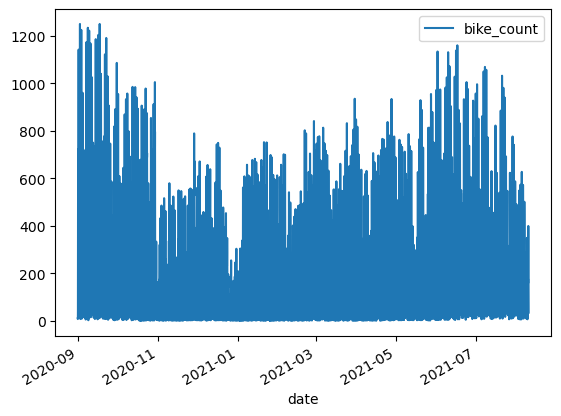

In [7]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].plot(x="date", y="bike_count")

Instead we aggregate the data, for instance, by week to have a clearer overall picture:

<Axes: xlabel='date'>

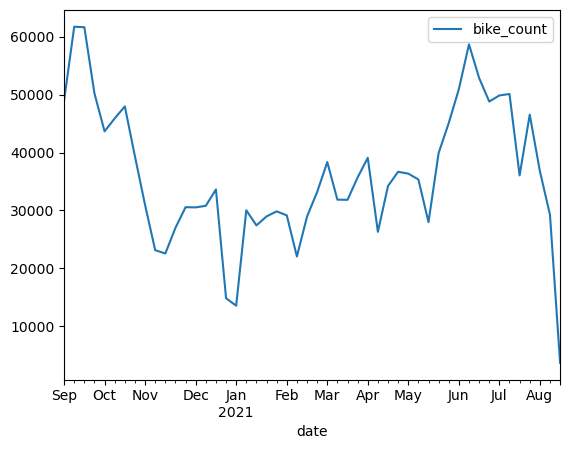

In [8]:
mask = (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")

data[mask].groupby(
    pd.Grouper(freq="1w", key="date")
)[["bike_count"]].sum().plot()

While at the same time, we can zoom on a week in particular for a more short-term visualization,

<Axes: xlabel='date'>

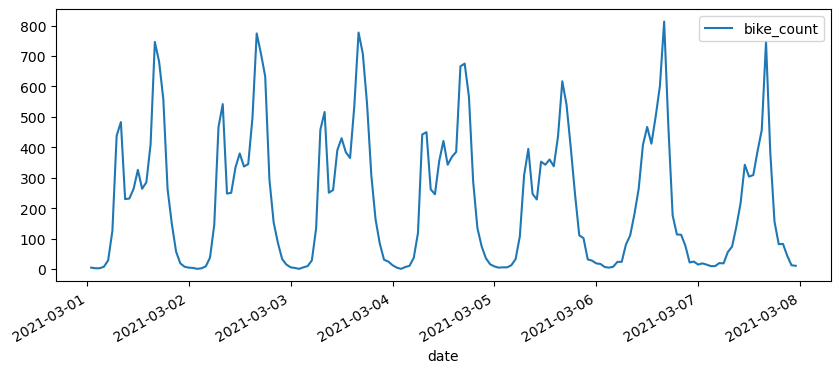

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data["date"] > pd.to_datetime("2021/03/01"))
    & (data["date"] < pd.to_datetime("2021/03/08"))
)

data[mask].plot(x="date", y="bike_count", ax=ax)

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

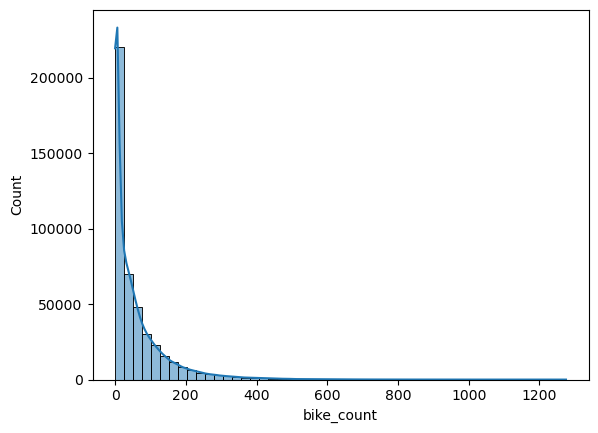

In [10]:
import seaborn as sns


ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

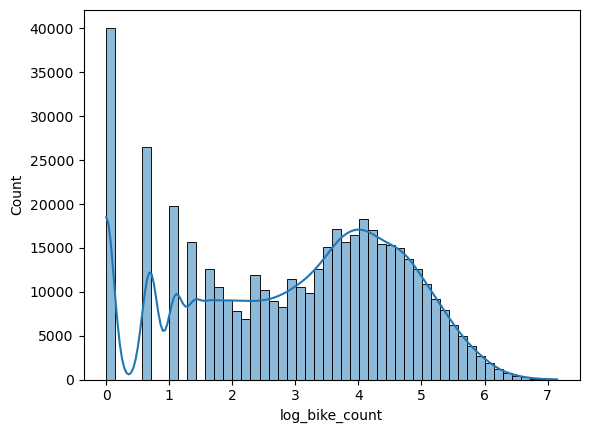

In [11]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

## Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field:

In [12]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [13]:
data["date"].head()

48321   2020-09-01 02:00:00
48324   2020-09-01 03:00:00
48327   2020-09-01 04:00:00
48330   2020-09-01 15:00:00
48333   2020-09-01 18:00:00
Name: date, dtype: datetime64[ns]

In [14]:
_encode_dates(data[["date"]].head())

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html):

In [15]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
sample_encoded = date_encoder.fit_transform(data[["date"]]).head()
sample_encoded

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

In [16]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)

enc.fit_transform(sample_encoded[["hour"]])

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

## Linear model

Let's now construct our first linear model with [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). We use a few helper functions defined in `utils.py` of the starting kit to load the train set.

In [17]:
import utils

X, y = utils.get_train_data()
X.head(2)

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233


and

In [18]:
y

array([1.60943791, 1.38629436, 0.        , ..., 2.48490665, 1.60943791,
       1.38629436])

Where `y` contains the `log_bike_count` variable. 

To test our baseline estimator, we create a validations set from the training set. Note that, during modeling and exploring the data, we always recommend using cross validation rather than a single train / validation split to evaluate your first results, because this will bring more stability and generalization.

We create the validation set by simply slicing the last 30 days of the training set:

In [19]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [20]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=414843,  2020-09-01 01:00:00 to 2021-07-10 23:00:00
Valid: n_samples=40320,  2021-07-11 00:00:00 to 2021-08-09 23:00:00


In [21]:
_encode_dates(X_train[["date"]]).columns.tolist()

['year', 'month', 'day', 'weekday', 'hour']

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x0000012646852E80>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

We then evaluate this model with the RMSE metric,

In [23]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

Train set, RMSE=0.80
Valid set, RMSE=0.85


The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [24]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_valid, np.full(y_valid.shape, y_valid.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.70
Test set, RMSE=1.42


which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations (we transform the logarithmic bike counts back to their original unit):

In [25]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/01"))
    & (X_valid["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

Text(0, 0.5, 'bike_count')

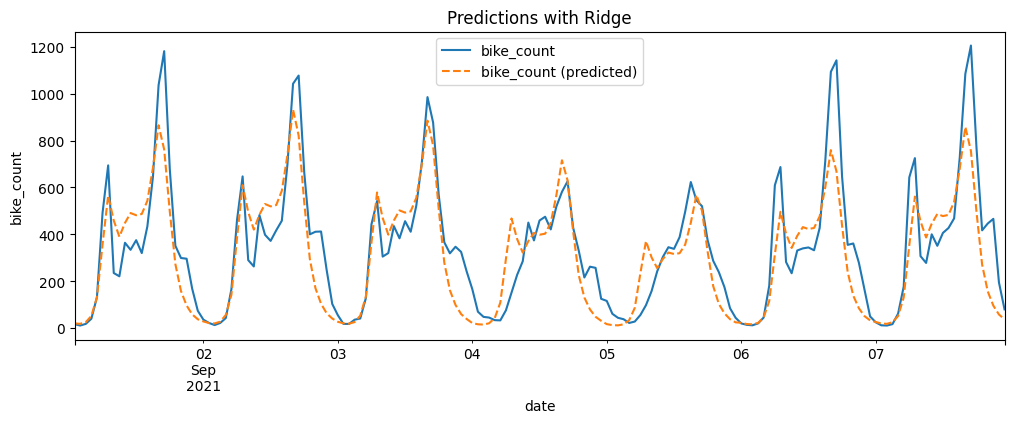

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

<Axes: xlabel='y_true', ylabel='y_pred'>

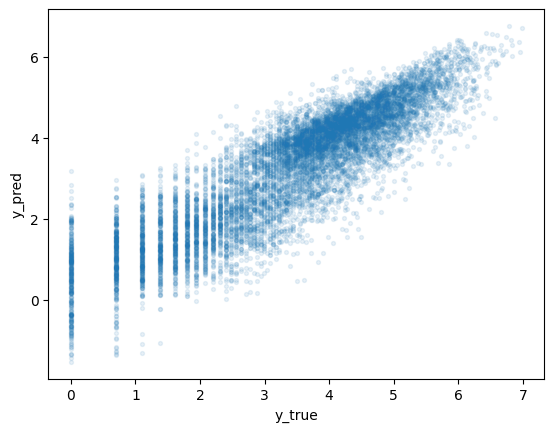

In [ ]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_valid, "y_pred": pipe.predict(X_valid)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html):

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores:

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.96370992 -0.87155645 -0.85104649 -0.87402962 -1.06387363 -0.96757066]
RMSE (all folds): 0.932 ± 0.0744


In [26]:
y_pred = pipe.predict(X_test)
results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
results.to_csv("submission.csv", index=False)

NameError: name 'X_test' is not defined

## Adding new features with external_data

In [45]:
# Import external data

external_data = pd.read_csv("external_data/external_data.csv")
external_data.columns

Index(['numer_sta', 'date', 'pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td',
       'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch',
       'pres', 'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24',
       'tminsol', 'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige',
       'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4'],
      dtype='object')

In [53]:
# Extract the dates from external_data for each row

external_data['date'] = pd.to_datetime(external_data['date'])
external_data[['date']].head()

,date
0,2021-01-01 00:00:00
1,2021-01-01 03:00:00
2,2021-01-01 06:00:00
3,2021-01-01 09:00:00
4,2021-01-01 12:00:00


In [54]:
external_data['pres']

0        99680
1        99790
2        99820
3        99970
4       100000
         ...  
3317    100480
3318    100270
3319    100090
3320     99960
3321     99820
Name: pres, Length: 3322, dtype: int64

In [48]:
# Select relevant weather features and copy the data of these columns

relevant_columns = ['date', 't', 'td', 'u', 'ff', 'rr3']
weather_data = external_data[relevant_columns].copy()

# Rename columns

column_names = { 'date': 'date',
                't': 'temperature',
                'td': 'dew point',
                'u': 'humidity',
                'ff': 'average wind speed',
                'rr3': 'precipitation'

}

weather_data = weather_data.rename(columns=column_names)

# Check that we have data for most dates

np.sum(weather_data.isna())

date                  0
temperature           0
dew point             0
humidity              0
average wind speed    0
precipitation         6
dtype: int64

In [49]:
# Deeper inspection of precipiation NAN values

weather_data[weather_data['precipitation'].isna()==True]

,date,temperature,dew point,humidity,average wind speed,precipitation
96,2021-01-13 00:00:00,278.95,278.05,94,0.5,NaN
276,2021-10-04 15:00:00,291.45,282.55,56,5.4,NaN
404,2021-10-20 15:00:00,292.55,287.15,71,7.6,NaN
919,2021-03-05 12:00:00,279.05,270.95,56,6.2,NaN
1399,2021-09-03 12:00:00,299.45,287.85,49,2.5,NaN
2730,2021-04-17 21:00:00,282.05,273.25,54,5.3,NaN


In [50]:
# Add these new features to the data and sort the data by date and counter_name

merged_data = pd.merge(data, weather_data, on='date', how='left')
merged_data = merged_data.sort_values(["date","counter_name"])

In [55]:
# Fill the missing values in the weather columns with values from later hours

max_date_data = max(data['date'])
max_date_weather_data = max(weather_data['date'])
weather_data_for_max_date_data = weather_data[weather_data['date']>max_date_data].sort_values(['date']).iloc[0][1:]
merged_data.iloc[-1,11:] = weather_data_for_max_date_data.values
merged_data.bfill(inplace=True)
merged_data

ValueError: Must have equal len keys and value when setting with an iterable

## Linear model with the new features

In [52]:
# Define input matrix X and target vector y

data = merged_data.sort_values(["date", "counter_name"])
y = data["log_bike_count"].values
X = data.drop(["log_bike_count", "bike_count"], axis=1)
X

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude,temperature_x,dew point_x,humidity_x,average wind speed_x,precipitation_x,temperature_y,dew point_y,humidity_y,average wind speed_y,precipitation_y
0,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,Y2H19027732,48.853720,2.357020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,Y2H19027732,48.853720,2.357020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,2020-09-01 01:00:00,2020-07-22,Y2H20073268,48.885290,2.326660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455320,100057329-103057329,Totem 85 quai d'Austerlitz SE-NO,100057329,Totem 85 quai d'Austerlitz,2021-08-09 23:00:00,2020-02-18,YTH19111508,48.842010,2.367290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
455321,100057380-104057380,Totem Cours la Reine E-O,100057380,Totem Cours la Reine,2021-08-09 23:00:00,2020-02-11,YTH19111509,48.864620,2.314440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
455322,100057380-103057380,Totem Cours la Reine O-E,100057380,Totem Cours la Reine,2021-08-09 23:00:00,2020-02-11,YTH19111509,48.864620,2.314440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
455323,100042374-110042374,Voie Georges Pompidou NE-SO,100042374,Voie Georges Pompidou,2021-08-09 23:00:00,2017-12-15,Y2H21025335,48.848400,2.275860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
y

array([1.60943791, 1.38629436, 0.        , ..., 2.48490665, 1.60943791,
       1.38629436])

In [43]:
# Split the data into train and test sets

X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=414897,  2020-09-01 01:00:00 to 2021-07-10 23:00:00
Valid: n_samples=40320,  2021-07-11 00:00:00 to 2021-08-09 23:00:00


In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_col = ["counter_name","site_name"]

# Preprocess the new features with a StandardScaler

scaler = StandardScaler()
weather_columns = weather_data.columns.drop("date").to_list()

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("weather", scaler, weather_columns)
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

ValueError: Input X contains NaN.
Ridge does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Compute the train and validation RMSE

from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

NotFittedError: This Ridge instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [215]:
# Compute CV RMSE

from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.98040958 -0.83763264 -0.93103558 -0.75574183 -0.95594224 -1.05842666]
RMSE (all folds): 0.92 ± 0.0983


In [216]:
# Import test data

X_test = pd.read_parquet(path="data/final_test.parquet")

# Add weather features to test data

merged_test_data = pd.merge(X_test, weather_data, on='date', how='left')
merged_test_data = merged_test_data.sort_values(["date","counter_name"])
merged_test_data.bfill(inplace=True)
merged_test_data

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,temperature,dew point,humidity,average wind speed,precipitation
17081,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2021-09-10 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,291.55,290.25,92.0,3.5,0.0
18655,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2021-09-10 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,291.55,290.25,92.0,3.5,0.0
3124,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,2021-09-10 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,291.55,290.25,92.0,3.5,0.0
4147,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,2021-09-10 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,291.55,290.25,92.0,3.5,0.0
48210,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,2021-09-10 01:00:00,2020-07-22,"48.88529,2.32666",Y2H20073268,48.885290,2.326660,291.55,290.25,92.0,3.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42131,100057329-103057329,Totem 85 quai d'Austerlitz SE-NO,100057329,Totem 85 quai d'Austerlitz,2021-10-18 21:00:00,2020-02-18,"48.84201,2.36729",YTH19111508,48.842010,2.367290,288.35,287.55,95.0,3.6,1.8
43042,100057380-104057380,Totem Cours la Reine E-O,100057380,Totem Cours la Reine,2021-10-18 21:00:00,2020-02-11,"48.86462,2.31444",YTH19111509,48.864620,2.314440,288.35,287.55,95.0,3.6,1.8
43929,100057380-103057380,Totem Cours la Reine O-E,100057380,Totem Cours la Reine,2021-10-18 21:00:00,2020-02-11,"48.86462,2.31444",YTH19111509,48.864620,2.314440,288.35,287.55,95.0,3.6,1.8
5707,100042374-110042374,Voie Georges Pompidou NE-SO,100042374,Voie Georges Pompidou,2021-10-18 21:00:00,2017-12-15,"48.8484,2.27586",Y2H21025335,48.848400,2.275860,288.35,287.55,95.0,3.6,1.8


In [214]:
# Predict y for X_test

y_pred = pipe.predict(merged_test_data)
results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
results.to_csv("submission_5.csv", index=False)

**SGD**

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

# Add a scaler for numerical features
numerical_cols = ["latitude", "longitude"]
numerical_encoder = StandardScaler()

date_encoder = FunctionTransformer(_encode_dates)

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", date_encoder, ["date"]),
        ("num", numerical_encoder, numerical_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = SGDRegressor()

pipe = make_pipeline(preprocessor, regressor)
pipe.fit(X_train, y_train)

NameError: name 'SGDRegressor' is not defined

In [ ]:
def remove_neg(y):
    y_pred = np.zeros(len(y))
    for i in range(len(y)):
        if y[i] > 0:
            y_pred[i] = y[i]
    return y_pred


In [ ]:
results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
results.to_csv("submission_sgd.csv", index=False)

**GradientBoosting**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Assuming X_train, X_valid, y_train, y_valid are already defined

def _encode_dates(X):
    X = X.copy()
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    return X.drop(columns=["date"])

date_encoder = FunctionTransformer(_encode_dates)
numerical_cols = ["latitude", "longitude"]
categorical_cols = ["site_name"]

preprocessor = ColumnTransformer(
    transformers=[
        ("date", date_encoder, ["date"]),
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

regressor = GradientBoostingRegressor()

pipe = make_pipeline(preprocessor, regressor)
pipe.fit(X_train, y_train)

# Evaluate the model
train_rmse = mean_squared_error(y_train, pipe.predict(X_train), squared=False)
valid_rmse = mean_squared_error(y_valid, pipe.predict(X_valid), squared=False)

print(f"Train set, RMSE={train_rmse:.2f}")
print(f"Valid set, RMSE={valid_rmse:.2f}")